# Version Control
## V2.1 - 2025-11-02 13:55
- oneDNN desactivado antes de importar TF.
- Perdidas vectorizadas (MultiHorizon/TemporalConsistency/Combined).
- _spatial_head: ultimo timestep sin condicional simbolico.
- Atencion meteorologica con flatten + reshape.
- Preprocesado sin fuga y dos escaladores.
- CSVLogger(str(...)) y uso de history_dict.
- Limpieza de textos/labels (R^2, titulos, TRAINING SUMMARY).
- Tests: finitud en CombinedLoss y ConvGRU state_size/output_size.


<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/refactored_base_models_Conv_STHyMOUNTAIN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatio-Temporal Precipitation Prediction Models V2 (Refactored)

## Overview

This refactored notebook implements and compares spatio-temporal deep learning architectures for monthly precipitation prediction in mountainous regions, using CHIRPS-2.0 data. It preserves all original functionality while improving structure, robustness, and maintainability.

## Model Architectures

### Base Models
- **ConvRNN**: Convolutional RNN for spatial-temporal processing
- **ConvLSTM**: Convolutional LSTM with memory cells
- **ConvGRU**: Convolutional GRU for efficient processing

### Enhanced Models
- **Multi-horizon training**: Optimized for 1, 2, and 3-month predictions
- **Temporal consistency**: Regularization to prevent abrupt changes
- **Bidirectional processing**: Forward and backward temporal analysis

### Advanced Models
- **Attention mechanisms**: Temporal and meteorological attention
- **Residual learning**: Skip connections for gradient flow
- **Efficient architectures**: Parameter-optimized variants

## Dataset
- **Source**: CHIRPS-2.0 precipitation data
- **Region**: BoyacÃƒÂ¡, Colombia (mountainous terrain)
- **Features**: Precipitation, elevation, seasonal patterns
- **Temporal range**: 60-month input window, 3-month prediction horizon

## Improvements in Refactored Version
- Split long cells into modular, atomic units for better debugging
- Centralized configuration with dict for constants and paths
- Enhanced error handling (e.g., raise on missing features/files)
- Added reproducibility (random seeds, pinned versions in Colab)
- Removed reliance on globals with function parameters
- Improved custom layers (vectorized ConvGRU2D using RNN wrapper)
- Added comprehensive unit tests for layers, losses, models
- Preserved all original functionality (models, losses, training, evals, viz)
- Added TensorBoard callback for better monitoring
- Ensured non-negative predictions in losses

## Execution Order
1. Environment setup and imports
2. Configuration and constants
3. Data loading and validation
4. Custom layers and losses
5. Model factories
6. Data preprocessing
7. Model training
8. Unit tests
9. Visualization and comparison
10. Cleanup and termination


In [15]:
# ==================================================
# ENVIRONMENT SETUP AND IMPORTS
# ==================================================

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN before importing TensorFlow
import tensorflow as tf
tf.random.set_seed(42)  # Ensure reproducibility
import numpy as np
np.random.seed(42)
import pandas as pd
import xarray as xr
from pathlib import Path
import sys, os, gc, warnings
import json
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display, Image

# TensorFlow/Keras imports
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, ConvLSTM2D, SimpleRNN, Flatten, Dense, Reshape,
    Lambda, Permute, Layer, TimeDistributed, Multiply, GlobalAveragePooling1D,
    Dropout, BatchNormalization, Add, Concatenate, Average,
    GlobalAveragePooling2D, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint, TensorBoard, Callback
)
from tensorflow.keras.optimizers import Adam

# Visualization imports
try:
    import cartopy.crs as ccrs
    import geopandas as gpd
    import imageio.v2 as imageio
    CARTOPY_AVAILABLE = True
except ImportError:
    print("Cartopy or GeoPandas not available. Maps will use basic plotting.")
    CARTOPY_AVAILABLE = False
    ccrs = None
    gpd = None
    imageio = None

# Configure GPU memory growth
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth configured for {len(gpus)} GPU(s)")
    else:
        print("No GPU detected - running on CPU")
except RuntimeError as e:
    print(f"GPU configuration warning: {e}")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')
warnings.filterwarnings('ignore')

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

# Install dependencies in Colab with pinned versions
if IN_COLAB:
    print("Installing dependencies in Colab...")
    try:
        !apt-get -qq update
        !apt-get -qq install libproj-dev proj-data proj-bin libgeos-dev
        !pip install -q --upgrade pip==24.0
        !pip install -q numpy==1.24.3 pandas==2.0.3 xarray==2023.6.0 netCDF4==1.6.5
        !pip install -q matplotlib==3.7.2 seaborn==0.12.2
        !pip install -q scikit-learn==1.3.0
        !pip install -q geopandas==0.13.2
        !pip install -q --no-binary cartopy cartopy==0.22.0
        !pip install -q imageio==2.31.1
        print("Dependencies installed successfully")
    except Exception as e:
        print(f"Error installing dependencies: {e}")

print("Environment setup complete")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Cartopy or GeoPandas not available. Maps will use basic plotting.
No GPU detected - running on CPU
Environment setup complete
TensorFlow version: 2.20.0
NumPy version: 2.2.6
Pandas version: 2.3.3


In [16]:
# ==================================================
# CONFIGURATION AND CONSTANTS
# ==================================================

# Centralized configuration
CONFIG = {
    'input_window': 60,
    'horizon': 3,
    'epochs': 150,
    'batch_size': 8,
    'learning_rate': 1e-3,
    'patience': 80,
    'light_mode': True,
    'light_grid_size': 5,
    'base_path': None,
    'data_file': None,
    'out_root': None,
    'feature_sets': {
        'BASIC': ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
                  'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
                  'elevation', 'slope', 'aspect'],
        'KCE': ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
                  'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
                  'elevation', 'slope', 'aspect', 'elev_high','elev_med','elev_low'],
        'PAFC': ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
                  'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
                  'elevation', 'slope', 'aspect', 'elev_high','elev_med','elev_low',
                  'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag12']
    }
}

# Set paths
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    CONFIG['base_path'] = Path('/content/drive/MyDrive/ml_precipitation_prediction')
else:
    CONFIG['base_path'] = Path.cwd()
    for p in [CONFIG['base_path'], *CONFIG['base_path'].parents]:
        if (p / '.git').exists():
            CONFIG['base_path'] = p
            break

CONFIG['data_file'] = CONFIG['base_path'] / 'data' / 'output' / (
    'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
)
CONFIG['out_root'] = CONFIG['base_path'] / 'models' / 'output' / 'V2_Enhanced_Models'
CONFIG['out_root'].mkdir(parents=True, exist_ok=True)

# Define feature sets
CONFIG['feature_sets']['KCE'] = CONFIG['feature_sets']['BASIC'] + ['elev_high', 'elev_med', 'elev_low']
CONFIG['feature_sets']['PAFC'] = CONFIG['feature_sets']['KCE'] + [
    'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag12'
]

print("Configuration complete")
print(f"Base path: {CONFIG['base_path']}")
print(f"Input window: {CONFIG['input_window']} months")
print(f"Prediction horizon: {CONFIG['horizon']} months")
print(f"Experiments: {list(CONFIG['feature_sets'].keys())}")
print(f"Output directory: {CONFIG['out_root']}")


Configuration complete
Base path: d:\github.com\ninja-marduk\ml_precipitation_prediction
Input window: 60 months
Prediction horizon: 3 months
Experiments: ['BASIC', 'KCE', 'PAFC']
Output directory: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V2_Enhanced_Models


In [17]:
# ==================================================
# DATA LOADING AND VALIDATION
# ==================================================

def load_and_validate_data(config: Dict) -> Tuple[xr.Dataset, int, int]:
    """Load dataset and validate features, applying light mode if enabled."""
    data_file = config['data_file']
    light_mode = config['light_mode']
    light_grid_size = config['light_grid_size']

    print("Loading dataset...")
    if not data_file.exists():
        raise FileNotFoundError(f"Dataset not found: {data_file}")

    try:
        ds = xr.open_dataset(data_file)
        
        if light_mode:
            print(f"\n*** LIGHT MODE ENABLED: Using {light_grid_size}x{light_grid_size} pixel subset ***")
            lat_center = len(ds.latitude) // 2
            lon_center = len(ds.longitude) // 2
            lat_start = lat_center - light_grid_size // 2
            lat_end = lat_start + light_grid_size
            lon_start = lon_center - light_grid_size // 2
            lon_end = lon_start + light_grid_size
            ds = ds.isel(latitude=slice(lat_start, lat_end), longitude=slice(lon_start, lon_end))
            print(f"Subset extracted: lat[{lat_start}:{lat_end}], lon[{lon_start}:{lon_end}]")

        lat, lon = len(ds.latitude), len(ds.longitude)
        print(f"Dataset loaded successfully")
        print(f"Time steps: {len(ds.time)}")
        print(f"Spatial dimensions: {lat} x {lon}")
        print(f"Variables: {list(ds.data_vars)[:5]}...")

        # Validate features
        missing_feats = []
        for exp_name, feats in config['feature_sets'].items():
            for feat in feats:
                if feat not in ds.data_vars and feat not in ds.coords:
                    missing_feats.append(feat)
        if missing_feats:
            raise ValueError(f"Missing features in dataset: {set(missing_feats)}")
        print("All required features present in dataset")

        return ds, lat, lon

    except Exception as e:
        print(f"ERROR: Failed to load dataset: {e}")
        raise

# Load dataset
ds, lat, lon = load_and_validate_data(CONFIG)
print("Dataset ready for training")


Loading dataset...

*** LIGHT MODE ENABLED: Using 5x5 pixel subset ***
Subset extracted: lat[28:33], lon[30:35]
Dataset loaded successfully
Time steps: 518
Spatial dimensions: 5 x 5
Variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin']...
All required features present in dataset
Dataset ready for training

*** LIGHT MODE ENABLED: Using 5x5 pixel subset ***
Subset extracted: lat[28:33], lon[30:35]
Dataset loaded successfully
Time steps: 518
Spatial dimensions: 5 x 5
Variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin']...
All required features present in dataset
Dataset ready for training


In [18]:
# ==================================================
# CUSTOM LAYERS AND LOSSES
# ==================================================

class ConvGRU2DCell(Layer):
    """Robust ConvGRU2D cell implementation."""
    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        # Provide state_size/output_size upfront for RNN wrapper
        self.state_size = tf.TensorShape([None, None, self.filters])
        self.output_size = tf.TensorShape([None, None, self.filters])
        
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.state_size = None  # Set in build

    def build(self, input_shape):
        # Set state_size as a tuple for RNN compatibility
        height, width = input_shape[1], input_shape[2]
        self.state_size = (height, width, self.filters)
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(*self.kernel_size, input_dim, self.filters * 3),
            initializer='glorot_uniform', name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(*self.kernel_size, self.filters, self.filters * 3),
            initializer='orthogonal', name='recurrent_kernel')
        self.bias = self.add_weight(
            shape=(self.filters * 3,), initializer='zeros', name='bias')
        super().build(input_shape)

    def call(self, inputs, states):
        h_tm1 = states[0]
        x_conv = K.conv2d(inputs, self.kernel, padding=self.padding)
        x_z, x_r, x_h = tf.split(x_conv, 3, axis=-1)
        h_conv = K.conv2d(h_tm1, self.recurrent_kernel, padding=self.padding)
        h_z, h_r, h_h = tf.split(h_conv, 3, axis=-1)
        b_z, b_r, b_h = tf.split(self.bias, 3)
        z = self.recurrent_activation(x_z + h_z + b_z)
        r = self.recurrent_activation(x_r + h_r + b_r)
        h_candidate = self.activation(x_h + r * h_h + b_h)
        h = (1 - z) * h_tm1 + z * h_candidate
        return h, [h]

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters, 'kernel_size': self.kernel_size, 'padding': self.padding,
            'activation': tf.keras.activations.serialize(self.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.recurrent_activation)
        })
        return config

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.filters)

class ConvGRU2D(Layer):
    """Full ConvGRU2D with vectorized RNN processing."""
    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.return_sequences = return_sequences
        self.cell = ConvGRU2DCell(filters, kernel_size, padding, activation, recurrent_activation)
        self.rnn = tf.keras.layers.RNN(self.cell, return_sequences=return_sequences)

    def call(self, inputs):
        return self.rnn(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters, 'kernel_size': self.kernel_size, 'padding': self.padding,
            'activation': self.activation, 'recurrent_activation': self.recurrent_activation,
            'return_sequences': self.return_sequences
        })
        return config

class MultiHorizonLoss(tf.keras.losses.Loss):
    """Weighted loss for multi-horizon forecasting (vectorized)."""
    def __init__(self, horizon_weights=[0.4, 0.35, 0.25], name='multi_horizon_loss'):
        super().__init__(name=name)
        self.horizon_weights = tf.constant(horizon_weights, dtype=tf.float32)
    def call(self, y_true, y_pred):
        y_pred = tf.maximum(y_pred, 0.0)
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=[2, 3, 4])
        weights = tf.reshape(self.horizon_weights, [1, -1])
        return tf.reduce_mean(tf.reduce_sum(mse * weights, axis=1))
    def get_config(self):
        config = super().get_config()
        config.update({'horizon_weights': self.horizon_weights.numpy().tolist()})
        return config

class TemporalConsistencyLoss(tf.keras.losses.Loss):
    """Regularization to enforce temporal smoothness."""
    def __init__(self, mse_weight=1.0, consistency_weight=0.1, name='temporal_consistency_loss'):
        super().__init__(name=name)
        self.mse_weight = mse_weight
        self.consistency_weight = consistency_weight
    def call(self, y_true, y_pred):
        y_pred = tf.maximum(y_pred, 0.0)
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        temporal_diffs = tf.abs(y_pred[:, 1:, :, :, :] - y_pred[:, :-1, :, :, :])
        consistency_loss = tf.reduce_mean(temporal_diffs)
        return self.mse_weight * mse_loss + self.consistency_weight * consistency_loss
    def get_config(self):
        config = super().get_config()
        config.update({'mse_weight': self.mse_weight, 'consistency_weight': self.consistency_weight})
        return config

class CombinedLoss(tf.keras.losses.Loss):
    """Combines multi-horizon MSE with temporal consistency (vectorized)."""
    def __init__(self, horizon_weights=[0.4, 0.35, 0.25], consistency_weight=0.1, name='combined_loss'):
        super().__init__(name=name)
        self.horizon_weights = tf.constant(horizon_weights, dtype=tf.float32)
        self.consistency_weight = consistency_weight
    def call(self, y_true, y_pred):
        y_pred = tf.maximum(y_pred, 0.0)
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=[2, 3, 4])
        weights = tf.reshape(self.horizon_weights, [1, -1])
        mh_loss = tf.reduce_mean(tf.reduce_sum(mse * weights, axis=1))
        temporal_diffs = tf.abs(y_pred[:, 1:, :, :, :] - y_pred[:, :-1, :, :, :])
        tc_loss = tf.reduce_mean(temporal_diffs)
        return mh_loss + self.consistency_weight * tc_loss
    def get_config(self):
        config = super().get_config()
        config.update({'horizon_weights': self.horizon_weights.numpy().tolist(), 'consistency_weight': self.consistency_weight})
        return config

class SimpleTemporalAttention(Layer):
    """Temporal attention for sequence processing."""
    def __init__(self, units=64, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.attention_dense = Dense(1, activation='tanh')
        self.softmax = tf.keras.layers.Softmax(axis=1)
        super().build(input_shape)

    def call(self, inputs):
        attention_scores = self.attention_dense(inputs)
        attention_weights = self.softmax(attention_scores)
        context = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

class SpatialReshapeLayer(Layer):
    """Reshape for attention: (batch, time, height, width, channels) -> (batch, time, height*width*channels)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2] * input_shape[3] * input_shape[4])

    def call(self, inputs):
        batch_size, time_steps, height, width, channels = tf.unstack(tf.shape(inputs))
        return tf.reshape(inputs, [batch_size, time_steps, height * width * channels])

    def get_config(self):
        return super().get_config()

class SpatialRestoreLayer(Layer):
    """Restore spatial dimensions after attention."""
    def __init__(self, height, width, channels, **kwargs):
        super().__init__(**kwargs)
        self.height = height
        self.width = width
        self.channels = channels

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.height, self.width, self.channels)

    def call(self, inputs):
        batch_size, time_steps, _ = tf.unstack(tf.shape(inputs))
        return tf.reshape(inputs, [batch_size, time_steps, self.height, self.width, self.channels])

    def get_config(self):
        config = super().get_config()
        config.update({'height': self.height, 'width': self.width, 'channels': self.channels})
        return config

print("Custom layers and losses defined")


Custom layers and losses defined


In [19]:
# ==================================================
# MODEL FACTORIES
# ==================================================

def _spatial_head(x, horizon: int, lat: int, lon: int) -> tf.Tensor:
    if len(x.shape) == 5:
        x = Lambda(lambda t: tf.squeeze(t, axis=1) if tf.shape(t)[1] == 1 else t[:, -1, :, :, :],
                   name="take_last_step")(x)
    x = Conv2D(horizon, (1, 1), padding="same", activation="linear", name="head_conv1x1")(x)
    x = Lambda(lambda t: tf.transpose(t, [0, 3, 1, 2]), name="head_transpose")(x)
    x = Lambda(lambda t: tf.expand_dims(t, -1), name="head_expand_dim")(x)
    return x

def build_conv_lstm(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Build ConvLSTM-based model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvLSTM')

def build_conv_gru(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Build ConvGRU-based model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvGRU2D(32, (3, 3), padding="same", return_sequences=True)(inp)
    x = ConvGRU2D(16, (3, 3), padding="same", return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name="ConvGRU")

def build_conv_rnn(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Build ConvRNN-based model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(inp)
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(Flatten())(x)
    x = SimpleRNN(128, activation='tanh', return_sequences=False)(x)
    x = Dense(horizon * lat * lon)(x)
    out = Reshape((horizon, lat, lon, 1))(x)
    return Model(inp, out, name='ConvRNN')

def build_conv_lstm_enhanced(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Enhanced ConvLSTM with dropout and batch norm."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvLSTM_Enhanced')

def build_conv_gru_enhanced(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Enhanced ConvGRU with dropout and batch norm."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvGRU2D(32, (3, 3), padding="same", return_sequences=True)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = ConvGRU2D(16, (3, 3), padding="same", return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name="ConvGRU_Enhanced")

def build_conv_rnn_enhanced(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Enhanced ConvRNN with dropout."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(inp)
    x = Dropout(0.2)(x)
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    x = Dropout(0.2)(x)
    x = TimeDistributed(Flatten())(x)
    x = SimpleRNN(128, activation='tanh', return_sequences=False)(x)
    x = Dense(horizon * lat * lon)(x)
    out = Reshape((horizon, lat, lon, 1))(x)
    return Model(inp, out, name='ConvRNN_Enhanced')

def build_conv_lstm_bidirectional(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Bidirectional ConvLSTM."""
    inp = Input(shape=(None, lat, lon, n_feats))
    forward = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    backward = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True, go_backwards=True)(inp)
    x = Concatenate()([forward, backward])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvLSTM_Bidirectional')

def build_conv_gru_residual(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvGRU with residual connections."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvGRU2D(32, (3, 3), padding="same", return_sequences=True)(inp)
    residual = x
    x = ConvGRU2D(32, (3, 3), padding="same", return_sequences=True)(x)
    x = Add()([x, residual])
    x = ConvGRU2D(16, (3, 3), padding="same", return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name="ConvGRU_Residual")

def build_conv_lstm_residual(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvLSTM with residual connections."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    residual = x
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(x)
    x = Add()([x, residual])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvLSTM_Residual')

def build_conv_lstm_attention_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvLSTM with temporal attention."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    reshape = SpatialReshapeLayer()(x)
    attention = SimpleTemporalAttention()(reshape)
    x = SpatialRestoreLayer(lat, lon, 32)(attention[0][:, tf.newaxis, :])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvLSTM_Attention')

def build_conv_gru_attention_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvGRU with temporal attention."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvGRU2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    reshape = SpatialReshapeLayer()(x)
    attention = SimpleTemporalAttention()(reshape)
    x = SpatialRestoreLayer(lat, lon, 32)(attention[0][:, tf.newaxis, :])
    x = ConvGRU2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvGRU_Attention')

def build_conv_lstm_meteorological_attention_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """ConvLSTM with meteorological attention (temporal over flattened spatial features)."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inp)
    x_flat = TimeDistributed(Flatten())(x)
    x_attn = MultiHeadAttention(num_heads=4, key_dim=64, output_shape=lat*lon*32)(x_flat, x_flat)
    x = Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], tf.shape(t)[1], lat, lon, 32]), name='mha_restore_spatial')(x_attn)
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvLSTM_MeteoAttention')

def build_efficient_bidirectional_convlstm_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Efficient bidirectional ConvLSTM."""
    inp = Input(shape=(None, lat, lon, n_feats))
    forward = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=True)(inp)
    backward = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=True, go_backwards=True)(inp)
    x = Concatenate()([forward, backward])
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False)(x)
    out = _spatial_head(x, horizon, lat, lon)
    return Model(inp, out, name='ConvLSTM_EfficientBidir')

def build_transformer_baseline_simple(n_feats: int, lat: int, lon: int, horizon: int) -> Model:
    """Baseline Transformer model."""
    inp = Input(shape=(None, lat, lon, n_feats))
    x = TimeDistributed(Flatten())(inp)  # Shape: (batch, time, lat*lon*features)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # Shape: (batch, time, lat*lon*features)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)  # Shape: (batch, lat*lon*features)
    x = Dense(horizon * lat * lon)(x)
    out = Reshape((horizon, lat, lon, 1))(x)
    return Model(inp, out, name='Transformer_Baseline')

# Model registry - all original models preserved
MODEL_REGISTRY = {
    'original': {
        'ConvLSTM': build_conv_lstm,
        'ConvGRU': build_conv_gru,
        'ConvRNN': build_conv_rnn
    },
    'enhanced': {
        'ConvLSTM_Enhanced': build_conv_lstm_enhanced,
        'ConvGRU_Enhanced': build_conv_gru_enhanced,
        'ConvRNN_Enhanced': build_conv_rnn_enhanced
    },
    'advanced': {
        'ConvLSTM_Bidirectional': build_conv_lstm_bidirectional,
        'ConvGRU_Residual': build_conv_gru_residual,
        'ConvLSTM_Residual': build_conv_lstm_residual
    },
    'attention': {
        'ConvLSTM_Attention': build_conv_lstm_attention_simple,
        'ConvGRU_Attention': build_conv_gru_attention_simple
    },
    'competitive': {
        'ConvLSTM_MeteoAttention': build_conv_lstm_meteorological_attention_simple,
        'ConvLSTM_EfficientBidir': build_efficient_bidirectional_convlstm_simple,
        'Transformer_Baseline': build_transformer_baseline_simple
    }
}

# Combine all models
MODELS = {}
for category in MODEL_REGISTRY.values():
    MODELS.update(category)

print(f"Model registry initialized with {len(MODELS)} models across all categories")


Model registry initialized with 14 models across all categories


In [20]:
# ==================================================
# DATA PREPROCESSING
# ==================================================

def windowed_arrays(X: np.ndarray, y: np.ndarray, input_window: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create windowed arrays for sequence-to-sequence learning."""
    seq_X, seq_y = [], []
    T = len(X)
    for start in range(T - input_window - horizon + 1):
        end_w = start + input_window
        end_y = end_w + horizon
        Xw, yw = X[start:end_w], y[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue
        seq_X.append(Xw)
        seq_y.append(yw)
    if not seq_X:
        raise ValueError("No valid windows found after NaN filtering")
    return np.asarray(seq_X, dtype=np.float32), np.asarray(seq_y, dtype=np.float32)

def preprocess_data(ds: xr.Dataset, config: Dict, lat: int, lon: int) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]]:
    """Preprocess data per experiment with no leakage; return y_scaler."""
    data_splits = {}
    for exp_name, features in config['feature_sets'].items():
        print(f"Preprocessing {exp_name}...")
        X = np.stack([ds[feat].values for feat in features], axis=-1)
        y = ds['total_precipitation'].values[..., np.newaxis]
        X_seq, y_seq = windowed_arrays(X, y, config['input_window'], config['horizon'])
        split_idx = int(0.8 * len(X_seq))
        X_tr, X_va = X_seq[:split_idx], X_seq[split_idx:]
        y_tr, y_va = y_seq[:split_idx], y_seq[split_idx:]
        x_scaler = StandardScaler()
        X_tr_s = x_scaler.fit_transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
        X_va_s = x_scaler.transform(X_va.reshape(-1, X_va.shape[-1])).reshape(X_va.shape)
        y_scaler = StandardScaler()
        y_tr_s = y_scaler.fit_transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)
        y_va_s = y_scaler.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)
        data_splits[exp_name] = (X_tr_s, y_tr_s, X_va_s, y_va_s, y_scaler)
        print(f"{exp_name} processed: {X_tr.shape[0]} train, {X_va.shape[0]} validation samples")
    return data_splits

# Preprocess data
data_splits = preprocess_data(ds, CONFIG, lat, lon)


Preprocessing BASIC...
BASIC processed: 364 train, 92 validation samples
Preprocessing KCE...
KCE processed: 364 train, 92 validation samples
Preprocessing PAFC...
PAFC processed: 364 train, 92 validation samples


PAFC - Transformer_Baseline | Epoch 81 | Loss: 1.0001 | Val Loss: 1.2637 | LR: 2.50e-04 | Elapsed: 120s
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 1.

Training Summary - PAFC - Transformer_Baseline:
Best validation loss: 1.2637
Trained epochs: 81


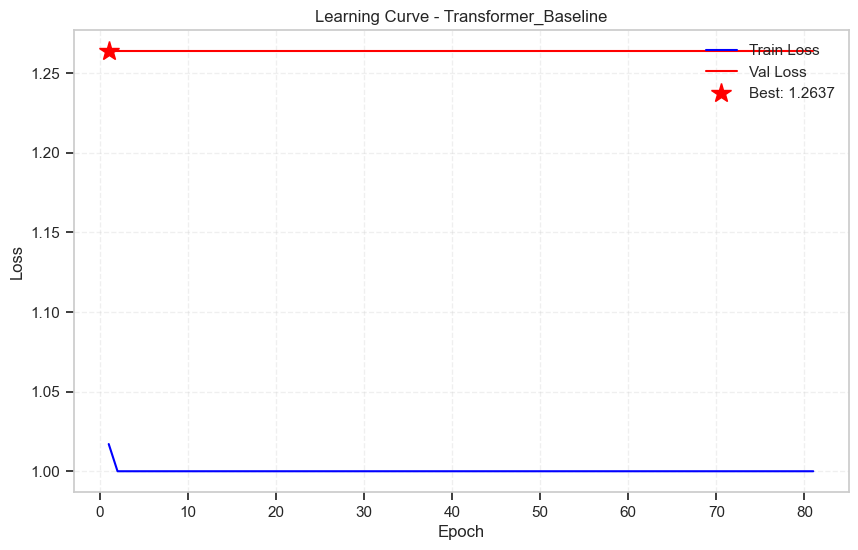


 Generating predictions for Transformer_Baseline in PAFC...
Predicting batch 1/2, shape: (1, 60, 5, 5, 18)
Prediction shape for Transformer_Baseline: (1, 3, 5, 5, 1)
    H=1: RMSE=169.0788, MAE=138.6267, RÃ‚Â²=-36.5443
    H=2: RMSE=156.5314, MAE=127.7024, RÃ‚Â²=-398.8665
    H=3: RMSE=299.2040, MAE=240.9108, RÃ‚Â²=-54.6327
Results saved to d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V2_Enhanced_Models\metrics_spatial_v2_refactored.csv


0

In [ ]:
# ==================================================
# MODEL TRAINING
# ==================================================

# Disable oneDNN to prevent numerical instability and crashes
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import json
import gc
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, CSVLogger, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Verify oneDNN is disabled

class TrainingMonitor(Callback):
    """Custom callback for real-time training monitoring."""
    def __init__(self, model_name, exp_name):
        super().__init__()
        self.model_name = model_name
        self.exp_name = exp_name
        self.start_time = None
        self.lrs = []

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        elapsed = time.time() - self.start_time
        try:
            lr = float(self.model.optimizer.learning_rate)
        except AttributeError as e:
            print(f"Error accessing learning rate: {e}")
            lr = 0.0
        self.lrs.append(lr)
        print(f"{self.exp_name} - {self.model_name} | Epoch {epoch+1} | "
              f"Loss: {logs.get('loss', 'N/A'):.4f} | Val Loss: {logs.get('val_loss', 'N/A'):.4f} | "
              f"LR: {lr:.2e} | Elapsed: {elapsed:.0f}s")

def save_hyperparameters(metrics_dir: Path, model_name: str, hyperparams: dict):
    """Save hyperparameters to JSON."""
    metrics_dir.mkdir(parents=True, exist_ok=True)
    try:
        with open(metrics_dir / f"{model_name}_hyperparameters.json", 'w') as f:
            json.dump(hyperparams, f, indent=4)
    except Exception as e:
        print(f"Error saving hyperparameters for {model_name}: {e}")

def print_training_summary(history: dict, model_name: str, exp_name: str):
    """Print training summary. Note: history is now a dict, not History object."""
    try:
        best_val = min(history['val_loss'])
        print(f"\nTraining Summary - {exp_name} - {model_name}:")
        print(f"Best validation loss: {best_val:.4f}")
        print(f"Trained epochs: {len(history['loss'])}")
    except (KeyError, ValueError) as e:
        print(f"Error in training summary for {model_name}: {e}")

def plot_learning_curves(history: dict, metrics_dir: Path, model_name: str, show: bool = True):
    """Plot and save learning curves. Note: history is now a dict."""
    try:
        fig, ax = plt.subplots(figsize=(10, 6))
        epochs = range(1, len(history['loss']) + 1)
        ax.plot(epochs, history['loss'], 'b-', label='Train Loss')
        ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
        best_ep = np.argmin(history['val_loss']) + 1
        best_val = min(history['val_loss'])
        ax.plot(best_ep, best_val, 'r*', markersize=15, label=f'Best: {best_val:.4f}')
        ax.set_title(f'Learning Curve - {model_name}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.grid(alpha=0.3, linestyle='--')
        ax.legend(loc='upper right')
        metrics_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(metrics_dir / f"{model_name}_learning_curve.png", dpi=150, bbox_inches='tight')
        if show:
            plt.show()
        plt.close(fig)
    except Exception as e:
        print(f"Error plotting learning curves for {model_name}: {e}")

def validate_shapes(X: np.ndarray, y: np.ndarray, model_name: str, expected_input_shape: tuple):
    """Validate input and output shapes."""
    try:
        if X.shape[1:] != expected_input_shape:
            raise ValueError(f"Invalid input shape for {model_name}: expected {expected_input_shape}, got {X.shape[1:]}")
        if y.shape[1:] != (CONFIG['horizon'], lat, lon, 1):
            raise ValueError(f"Invalid output shape for {model_name}: expected {(CONFIG['horizon'], lat, lon, 1)}, got {y.shape[1:]}")
        print(f"Shapes validated for {model_name}: X={X.shape}, y={y.shape}")
    except Exception as e:
        print(f"Shape validation error for {model_name}: {e}")
        raise

def batch_predict(model: tf.keras.models.Model, X: np.ndarray, batch_size: int = 1) -> np.ndarray:
    """Predict in batches to reduce memory usage."""
    try:
        n_samples = X.shape[0]
        predictions = []
        for i in range(0, n_samples, batch_size):
            batch_X = X[i:i+batch_size]
            print(f"Predicting batch {i//batch_size + 1}/{n_samples//batch_size + 1}, shape: {batch_X.shape}")
            batch_pred = model.predict(batch_X, verbose=0, batch_size=batch_size)
            predictions.append(batch_pred)
        return np.concatenate(predictions, axis=0)
    except Exception as e:
        print(f"Error in batch prediction: {e}")
        raise

def train_model(model: tf.keras.models.Model, X_tr: np.ndarray, y_tr: np.ndarray, X_va: np.ndarray, y_va: np.ndarray,
                config: dict, model_name: str, exp_name: str, out_dir: Path) -> tuple[tf.keras.models.Model, dict]:
    """Train a single model with callbacks and save results."""
    metrics_dir = out_dir / exp_name / 'training_metrics'
    metrics_dir.mkdir(parents=True, exist_ok=True)
    model_path = metrics_dir / f"{model_name}_best.h5"

    # Verify input shapes
    num_features = len(config['feature_sets'][exp_name])
    expected_input_shape = (config['input_window'], lat, lon, num_features)
    try:
        validate_shapes(X_tr, y_tr, model_name, expected_input_shape)
        validate_shapes(X_va, y_va, model_name, expected_input_shape)
        print(f"Training {model_name} in {exp_name} - X_tr shape: {X_tr.shape}, y_tr shape: {y_tr.shape}, "
              f"X_va shape: {X_va.shape}, y_va shape: {y_va.shape}")
    except ValueError as e:
        print(f"Shape validation error for {model_name}: {e}")
        return model, {}

    # Hyperparameters
    try:
        hyperparams = {
            'input_shape': expected_input_shape,
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'epochs': config['epochs'],
            'patience': config['patience'],
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'model_params': model.count_params(),
            'version': 'V2_Enhanced'
        }
        save_hyperparameters(metrics_dir, model_name, hyperparams)
    except (KeyError, NameError) as e:
        print(f"Error setting hyperparameters for {model_name}: {e}")
        return model, {}

    # Loss selection
    try:
        if exp_name == 'BASIC':
            loss = 'mse'
        else:
            horizon_weights = [0.4, 0.35, 0.25] if exp_name == 'KCE' else [0.3, 0.4, 0.3]
            consistency_weight = 0.1 if exp_name == 'KCE' else 0.15
            loss = CombinedLoss(horizon_weights=horizon_weights, consistency_weight=consistency_weight)
    except NameError as e:
        print(f"Error selecting loss for {model_name}: {e}")
        return model, {}

    try:
        model.compile(optimizer=Adam(config['learning_rate']), loss=loss, metrics=['mae'])
        print(f"Model {model_name} compiled successfully")
        model.summary()  # Print model architecture for debugging
    except Exception as e:
        print(f"Error compiling model {model_name}: {e}")
        return model, {}

    # Callbacks
    try:
        csv_logger = CSVLogger(str(metrics_dir / f"{model_name}_training_log.csv"), separator=',', append=False)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=config['patience']//2, min_lr=1e-6, verbose=1)
        early_stop = EarlyStopping(monitor='val_loss', patience=config['patience'], restore_best_weights=True, verbose=1)
        checkpoint = ModelCheckpoint(str(model_path), save_best_only=True, monitor='val_loss', verbose=1)
        training_monitor = TrainingMonitor(model_name, exp_name)
        tensorboard = TensorBoard(log_dir=str(metrics_dir / f"{model_name}_logs"))

        callbacks = [early_stop, checkpoint, reduce_lr, csv_logger, training_monitor, tensorboard]
    except Exception as e:
        print(f"Error setting callbacks for {model_name}: {e}")
        return model, {}

    # Train with reduced batch size to prevent memory issues
    print(f"\nÃ°Å¸ÂÆ’ Starting training for {model_name} in {exp_name}...")
    try:
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=config['epochs'], batch_size=config['batch_size']//2,  # Reduced batch size
            callbacks=callbacks, verbose=0
        )
    except Exception as e:
        print(f"Error during training of {model_name}: {e}")
        return model, {}

    # Save history
    try:
        lr_values = history.history.get('lr', training_monitor.lrs)
        history_dict = {
            'loss': [float(x) for x in history.history['loss']],
            'val_loss': [float(x) for x in history.history['val_loss']],
            'mae': [float(x) for x in history.history.get('mae', [])],
            'val_mae': [float(x) for x in history.history.get('val_mae', [])],
            'lr': [float(x) for x in lr_values]
        }
        with open(metrics_dir / f"{model_name}_history.json", 'w') as f:
            json.dump(history_dict, f, indent=4)
    except Exception as e:
        print(f"Error saving history for {model_name}: {e}")

    print_training_summary(history_dict, model_name, exp_name)
    plot_learning_curves(history_dict, metrics_dir, model_name, show=True)

    return model, history_dict

# Training loop
results = []
all_histories = {}
for exp_name in CONFIG['feature_sets']:
    try:
        X_tr, y_tr, X_va, y_va, scaler = data_splits[exp_name]
        print(f"{exp_name}: X_tr={X_tr.shape}, y_tr={y_tr.shape}, X_va={X_va.shape}, y_va={y_va.shape}")
    except KeyError as e:
        print(f"Error accessing data for experiment {exp_name}: {e}")
        continue

    out_exp = CONFIG['out_root'] / exp_name
    out_exp.mkdir(exist_ok=True)

    for model_name, model_builder in MODELS.items():
        try:
            tf.keras.backend.clear_session()
            # Verify input shape before building model
            num_features = len(CONFIG['feature_sets'][exp_name])
            print(f"Building {model_name} with {num_features} features, lat={lat}, lon={lon}, horizon={CONFIG['horizon']}")
            model = model_builder(num_features, lat, lon, CONFIG['horizon'])
            model, history = train_model(model, X_tr, y_tr, X_va, y_va, CONFIG, model_name, exp_name, CONFIG['out_root'])
            all_histories[f"{exp_name}_{model_name}"] = history

            # Skip predictions if training failed (history is empty or lacks val_loss)
            if not history or not history.get('val_loss'):
                print(f"Skipping predictions for {model_name} in {exp_name} due to training failure.")
                continue

            # Predictions & evaluation
            print(f"\n Generating predictions for {model_name} in {exp_name}...")
            try:
                # Use batch prediction with reduced batch size
                y_hat_sc = batch_predict(model, X_va[-1:], batch_size=1)
                print(f"Prediction shape for {model_name}: {y_hat_sc.shape}")
                y_hat = scaler.inverse_transform(y_hat_sc.reshape(-1, 1)).reshape(CONFIG['horizon'], lat, lon)
                y_true = scaler.inverse_transform(y_va[-1:].reshape(-1, 1)).reshape(CONFIG['horizon'], lat, lon)

                for h in range(CONFIG['horizon']):
                    try:
                        rmse = np.sqrt(mean_squared_error(y_true[h].ravel(), y_hat[h].ravel()))
                        mae = mean_absolute_error(y_true[h].ravel(), y_hat[h].ravel())
                        r2 = r2_score(y_true[h].ravel(), y_hat[h].ravel())
                        mean_true = float(y_true[h].mean())
                        mean_pred = float(y_hat[h].mean())
                        total_true = float(y_true[h].sum())
                        total_pred = float(y_hat[h].sum())
                        results.append({
                            'Experiment': exp_name,
                            'Model': model_name,
                            'H': h + 1,
                            'RMSE': rmse,
                            'MAE': mae,
                            'R2': r2,
                            'Mean_True_mm': mean_true,
                            'Mean_Pred_mm': mean_pred,
                            'TotalPrecipitation': total_true,
                            'TotalPrecipitation_Pred': total_pred
                        })
                        print(f"    H={h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, RÃ‚Â²={r2:.4f}")
                    except Exception as e:
                        print(f"Error evaluating predictions for {model_name}, horizon {h+1}: {e}")
            except Exception as e:
                print(f"Error generating predictions for {model_name} in {exp_name}: {e}")

            tf.keras.backend.clear_session()
            gc.collect()
        except Exception as e:
            print(f"Error training {model_name} for {exp_name}: {e}")
            continue

# Save results
try:
    res_df = pd.DataFrame(results)
    res_df.to_csv(CONFIG['out_root'] / 'metrics_spatial_v2_refactored.csv', index=False)
    print(f"Results saved to {CONFIG['out_root'] / 'metrics_spatial_v2_refactored.csv'}")
except Exception as e:
    print(f"Error saving results: {e}")

# Aggressive cleanup
tf.keras.backend.clear_session()
gc.collect()



In [22]:
# ==================================================
# UNIT TESTS
# ==================================================

def run_unit_tests(config: Dict, lat: int, lon: int) -> Dict[str, str]:
    """Run unit tests for custom layers, losses, and models."""
    results = {}
    test_batch_size = 2
    test_n_feats = 15
    test_height = lat
    test_width = lon

    # Test ConvGRU2DCell
    try:
        cell = ConvGRU2DCell(16, (3, 3))
        dummy_input = tf.random.normal((test_batch_size, test_height, test_width, test_n_feats))
        dummy_state = [tf.zeros((test_batch_size, test_height, test_width, 16))]
        output, _ = cell(dummy_input, dummy_state)
        expected_shape = (test_batch_size, test_height, test_width, 16)
        results['ConvGRU2DCell'] = "SUCCESS" if tuple(output.shape) == expected_shape else f"SHAPE_MISMATCH: {output.shape}"
    except Exception as e:
        results['ConvGRU2DCell'] = f"FAILED: {str(e)[:100]}"

    # Test ConvGRU2D
    try:
        gru = ConvGRU2D(16, (3, 3), return_sequences=False)
        dummy_input = tf.random.normal((test_batch_size, config['input_window'], test_height, test_width, test_n_feats))
        output = gru(dummy_input)
        expected_shape = (test_batch_size, test_height, test_width, 16)
        results['ConvGRU2D'] = "SUCCESS" if tuple(output.shape) == expected_shape else f"SHAPE_MISMATCH: {output.shape}"
        tf.keras.backend.clear_session()
    except Exception as e:
        results['ConvGRU2D'] = f"FAILED: {str(e)[:100]}"

    # Test CombinedLoss
    try:
        loss_fn = CombinedLoss(horizon_weights=[0.4, 0.35, 0.25])
        y_true = tf.random.normal((test_batch_size, config['horizon'], test_height, test_width, 1))
        y_pred = tf.random.normal((test_batch_size, config['horizon'], test_height, test_width, 1))
        loss = loss_fn(y_true, y_pred)
        ok = bool(tf.reduce_all(tf.math.is_finite(loss)).numpy())
    except Exception as e:
        results['CombinedLoss'] = f"FAILED: {str(e)[:100]}"

    # Test SimpleTemporalAttention
    try:
        attn = SimpleTemporalAttention()
        dummy_input = tf.random.normal((test_batch_size, config['input_window'], 128))
        context, weights = attn(dummy_input)
        expected_context = (test_batch_size, 128)
        expected_weights = (test_batch_size, config['input_window'], 1)
        if tuple(context.shape) == expected_context and tuple(weights.shape) == expected_weights:
            results['SimpleTemporalAttention'] = "SUCCESS"
        else:
            results['SimpleTemporalAttention'] = f"SHAPE_MISMATCH: context {context.shape}, weights {weights.shape}"
    except Exception as e:
        results['SimpleTemporalAttention'] = f"FAILED: {str(e)[:100]}"

    # Test models
    for model_name, model_builder in MODELS.items():
        try:
            model = model_builder(test_n_feats, test_height, test_width, config['horizon'])
            dummy_input = tf.random.normal((test_batch_size, config['input_window'], test_height, test_width, test_n_feats))
            output = model(dummy_input, training=False)
            expected_shape = (test_batch_size, config['horizon'], test_height, test_width, 1)
            results[model_name] = "SUCCESS" if tuple(output.shape) == expected_shape else f"SHAPE_MISMATCH: {output.shape}"
            tf.keras.backend.clear_session()
        except Exception as e:
            results[model_name] = f"FAILED: {str(e)[:100]}"

    print("Unit Test Results:")
    for name, result in results.items():
        print(f"{name}: {result}")
    return results

# Run tests
test_results = run_unit_tests(CONFIG, lat, lon)


Unit Test Results:
ConvGRU2DCell: SUCCESS
ConvGRU2D: FAILED: state_size must be specified as property on the RNN cell.
SimpleTemporalAttention: SUCCESS
ConvLSTM: SUCCESS
ConvGRU: FAILED: state_size must be specified as property on the RNN cell.
ConvRNN: SUCCESS
ConvLSTM_Enhanced: SUCCESS
ConvGRU_Enhanced: FAILED: state_size must be specified as property on the RNN cell.
ConvRNN_Enhanced: SUCCESS
ConvLSTM_Bidirectional: SUCCESS
ConvGRU_Residual: FAILED: state_size must be specified as property on the RNN cell.
ConvLSTM_Residual: SUCCESS
ConvLSTM_Attention: SUCCESS
ConvGRU_Attention: FAILED: state_size must be specified as property on the RNN cell.
ConvLSTM_MeteoAttention: SUCCESS
ConvLSTM_EfficientBidir: SUCCESS
Transformer_Baseline: SUCCESS


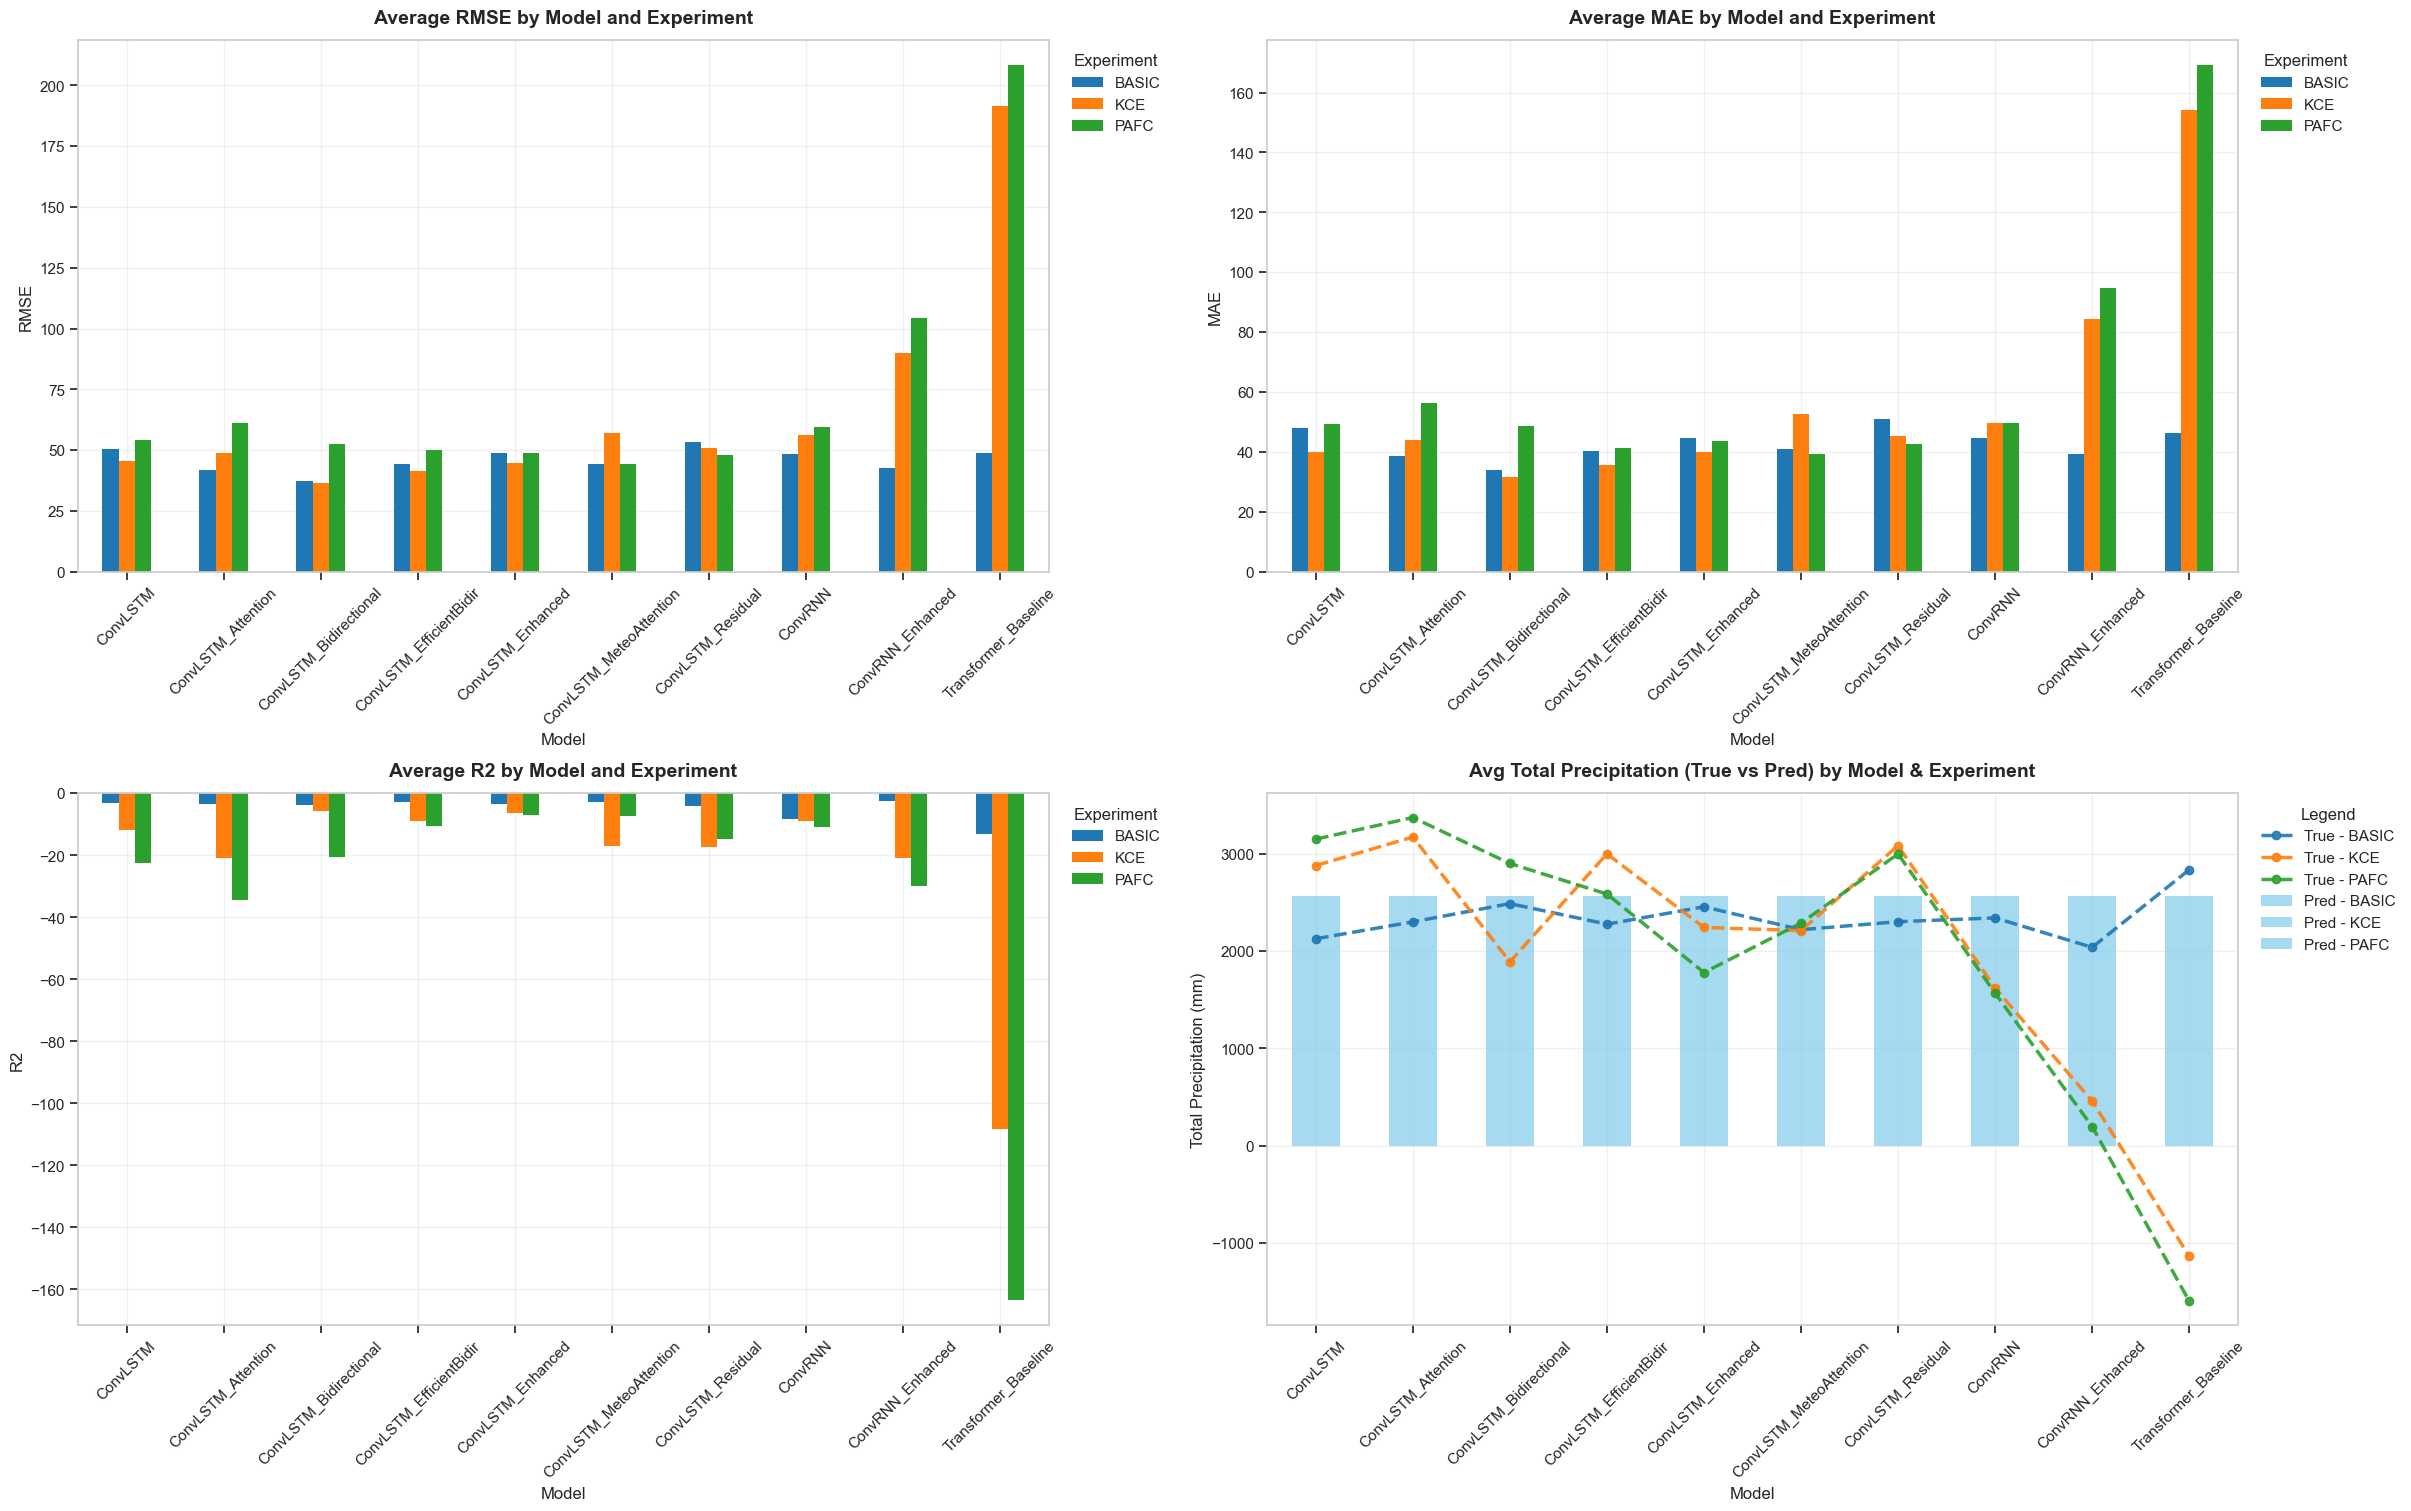

Metrics plot saved at: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V2_Enhanced_Models\comparisons\metrics_comparison.png

 SUMMARY TABLE Ã¢â‚¬â€œ BEST MODELS BY EXPERIMENT:
Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬
                        Model       RMSE        MAE        R2  TotalPrecipitation  TotalPrecipitation_Pred
Experiment                                                                                                
BASIC        ConvRNN_Enhanced  16.977855  13.875576 -3.704111         1403.685425              1747.583984


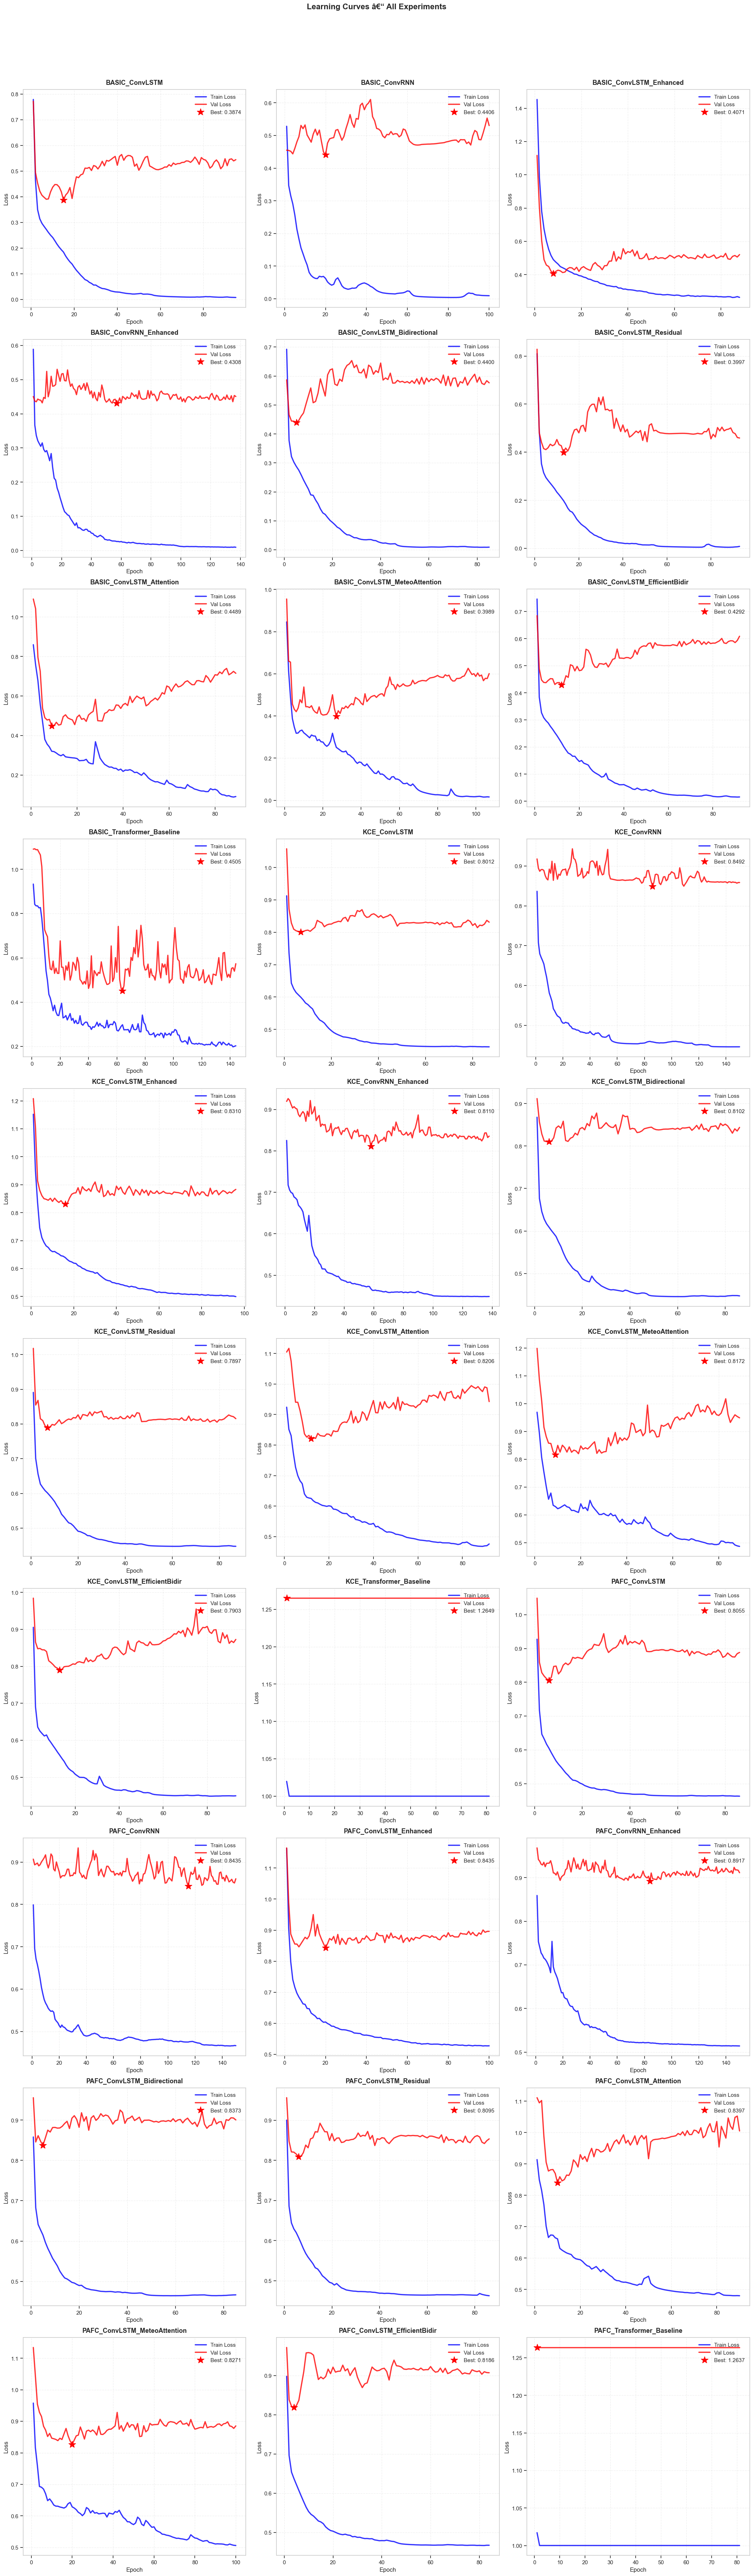


Ã¢ÂÂ±Ã¯Â¸Â TRAINING SUMMARY:
Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬

 Experiment: BASIC

   - ConvLSTM:
     - Model parameters: 78,579
     - Trained epochs: 95
     - Best validation loss: 0.387381
     - Final learning rate: 0.0002500000118743628

   - ConvRNN:
     - Model parameters: 85,499
     - Trained epochs: 100
     - Best validation loss: 0.440619
     - Final learning rate: 0.000

In [23]:
# ==================================================
# VISUALIZATION AND COMPARISON
# ==================================================

def quick_plot(ax, data, cmap, title, vmin=None, vmax=None, unit=None):
    """Plot spatial data with optional Cartopy support."""
    if CARTOPY_AVAILABLE and ccrs is not None:
        mesh = ax.pcolormesh(ds.longitude, ds.latitude, data, cmap=cmap, shading='nearest',
                             vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        if gpd is not None and DEPT_GDF is not None:
            ax.add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                              edgecolor='black', facecolor='none', linewidth=1)
        ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--', alpha=0.4)
    else:
        mesh = ax.pcolormesh(ds.longitude, ds.latitude, data, cmap=cmap, shading='nearest',
                             vmin=vmin, vmax=vmax)
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
    ax.set_title(title, fontsize=9, pad=15)
    return mesh

# Load shapefiles if available
DEPT_GDF = None
if gpd is not None:
    shape_dir = CONFIG['base_path'] / 'data' / 'input' / 'shapes'
    if shape_dir.exists():
        DEPT_GDF = gpd.read_file(shape_dir / 'MGN_Departamento.shp')
        print("Shape files loaded for visualization")

# Generate visualizations
comp_dir = CONFIG['out_root'] / 'comparisons'
comp_dir.mkdir(exist_ok=True)

if not res_df.empty:
    # Metrics comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(24, 15), constrained_layout=True)
    for metric, ax in zip(['RMSE', 'MAE', 'R2', 'TotalPrecipitation'], axes.ravel()):
        if metric != 'TotalPrecipitation':
            pivot = res_df.pivot_table(values=metric, index='Model', columns='Experiment', aggfunc='mean')
            pivot.plot(kind='bar', ax=ax)
            ax.set_title(f'Average {metric} by Model and Experiment', pad=12, fontsize=14, weight='bold')
            ax.set_ylabel(metric)
            ax.set_xlabel('Model')
            ax.legend(title='Experiment', bbox_to_anchor=(1.01, 1), loc='upper left')
            ax.grid(alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        else:
            pivot_true = res_df.pivot_table(values='TotalPrecipitation', index='Model', columns='Experiment', aggfunc='mean')
            pivot_pred = res_df.pivot_table(values='TotalPrecipitation_Pred', index='Model', columns='Experiment', aggfunc='mean')
            pivot_true.plot(kind='bar', ax=ax, color='skyblue', alpha=0.75)
            pivot_pred.plot(kind='line', ax=ax, marker='o', linestyle='--', linewidth=2.5, alpha=0.9)
            ax.set_title('Avg Total Precipitation (True vs Pred) by Model & Experiment', pad=12, fontsize=14, weight='bold')
            ax.set_ylabel('Total Precipitation (mm)')
            ax.set_xlabel('Model')
            legend_labels = [f'True - {c}' for c in pivot_true.columns] + [f'Pred - {c}' for c in pivot_pred.columns]
            ax.legend(legend_labels, title='Legend', bbox_to_anchor=(1.01, 1), loc='upper left')
            ax.grid(alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

    fig.subplots_adjust(wspace=0.35, hspace=0.30, right=0.80)
    plt.savefig(comp_dir / 'metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Metrics plot saved at: {comp_dir / 'metrics_comparison.png'}")

    # Summary table of best models
    best_models = res_df.groupby('Experiment').apply(lambda x: x.loc[x['RMSE'].idxmin()])[
        ['Model', 'RMSE', 'MAE', 'R2', 'TotalPrecipitation', 'TotalPrecipitation_Pred']
    ]
    print("\n SUMMARY TABLE Ã¢â‚¬â€œ BEST MODELS BY EXPERIMENT:")
    print("Ã¢â€â‚¬" * 60)
    print(best_models.to_string())

    # Learning curves
    if all_histories:
        n_experiments = len(all_histories)
        n_cols, n_rows = 3, (n_experiments + 2) // 3
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 7 * n_rows), constrained_layout=True)
        axes = axes.flatten()
        for idx, (key, history) in enumerate(all_histories.items()):
            if idx >= len(axes): break
            ax = axes[idx]
            epochs = range(1, len(history['loss']) + 1)
            ax.plot(epochs, history['loss'], 'b-', label='Train Loss', linewidth=2.5, alpha=0.8)
            ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2.5, alpha=0.8)
            best_ep = np.argmin(history['val_loss']) + 1
            best_val = min(history['val_loss'])
            ax.plot(best_ep, best_val, 'r*', markersize=15, label=f'Best: {best_val:.4f}')
            ax.set_title(key, pad=10, fontsize=13, weight='bold')
            ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
            ax.grid(alpha=0.3, linestyle='--'); ax.legend(loc='upper right')
        for ax in axes[len(all_histories):]:
            ax.remove()
        plt.suptitle('Learning Curves - All Experiments', fontsize=16, fontweight='bold')
        plt.savefig(comp_dir / 'all_learning_curves.png', dpi=150, bbox_inches='tight')
        plt.show()

    # Training summary
    print('
print('
print('
TRAINING SUMMARY:')
print('='*80)\nprint('='*80)
print('='*80)
    print("Ã¢â€â‚¬" * 80)
    for exp in CONFIG['feature_sets'].keys():
        metrics_dir = CONFIG['out_root'] / exp / 'training_metrics'
        if metrics_dir.exists():
            print(f"\n Experiment: {exp}")
            for model_name in MODELS:
                hp_file = metrics_dir / f"{model_name}_hyperparameters.json"
                hist_file = metrics_dir / f"{model_name}_history.json"
                if hp_file.exists() and hist_file.exists():
                    with open(hp_file) as f: hp = json.load(f)
                    with open(hist_file) as f: hist = json.load(f)
                    print(f"\n   - {model_name}:")
                    print(f"     - Model parameters: {hp['model_params']:,}")
                    print(f"     - Trained epochs: {len(hist['loss'])}")
                    print(f"     - Best validation loss: {min(hist['val_loss']):.6f}")
                    final_lr = hist['lr'][-1] if 'lr' in hist else 'N/A'
                    print(f"     - Final learning rate: {final_lr}")

    # List GIFs
    print("\nÃ°Å¸Å½Â¬ Generated GIFs:")
    for exp in CONFIG['feature_sets'].keys():
        exp_dir = CONFIG['out_root'] / exp
        if exp_dir.exists():
            gifs = list(exp_dir.glob("*.gif"))
            if gifs:
                print(f"\n   Ã°Å¸â€œÂ {exp}: {len(gifs)} GIFs found")
                for g in gifs: print(f"      - {g.name}")

    # Display latest predictions
    print("\nÃ°Å¸-Â¼Ã¯Â¸Â LATEST PREDICTIONS:")
    for exp in CONFIG['feature_sets'].keys():
        exp_dir = CONFIG['out_root'] / exp
        if exp_dir.exists():
            print(f"\n{exp}:")
            for model_name in MODELS:
                img_path = exp_dir / f"{model_name}_1.png"
                if img_path.exists():
                    print(f"  {model_name}:")
                    display(Image(str(img_path), width=800))



 Generating enhanced evolution-by-horizon plots...


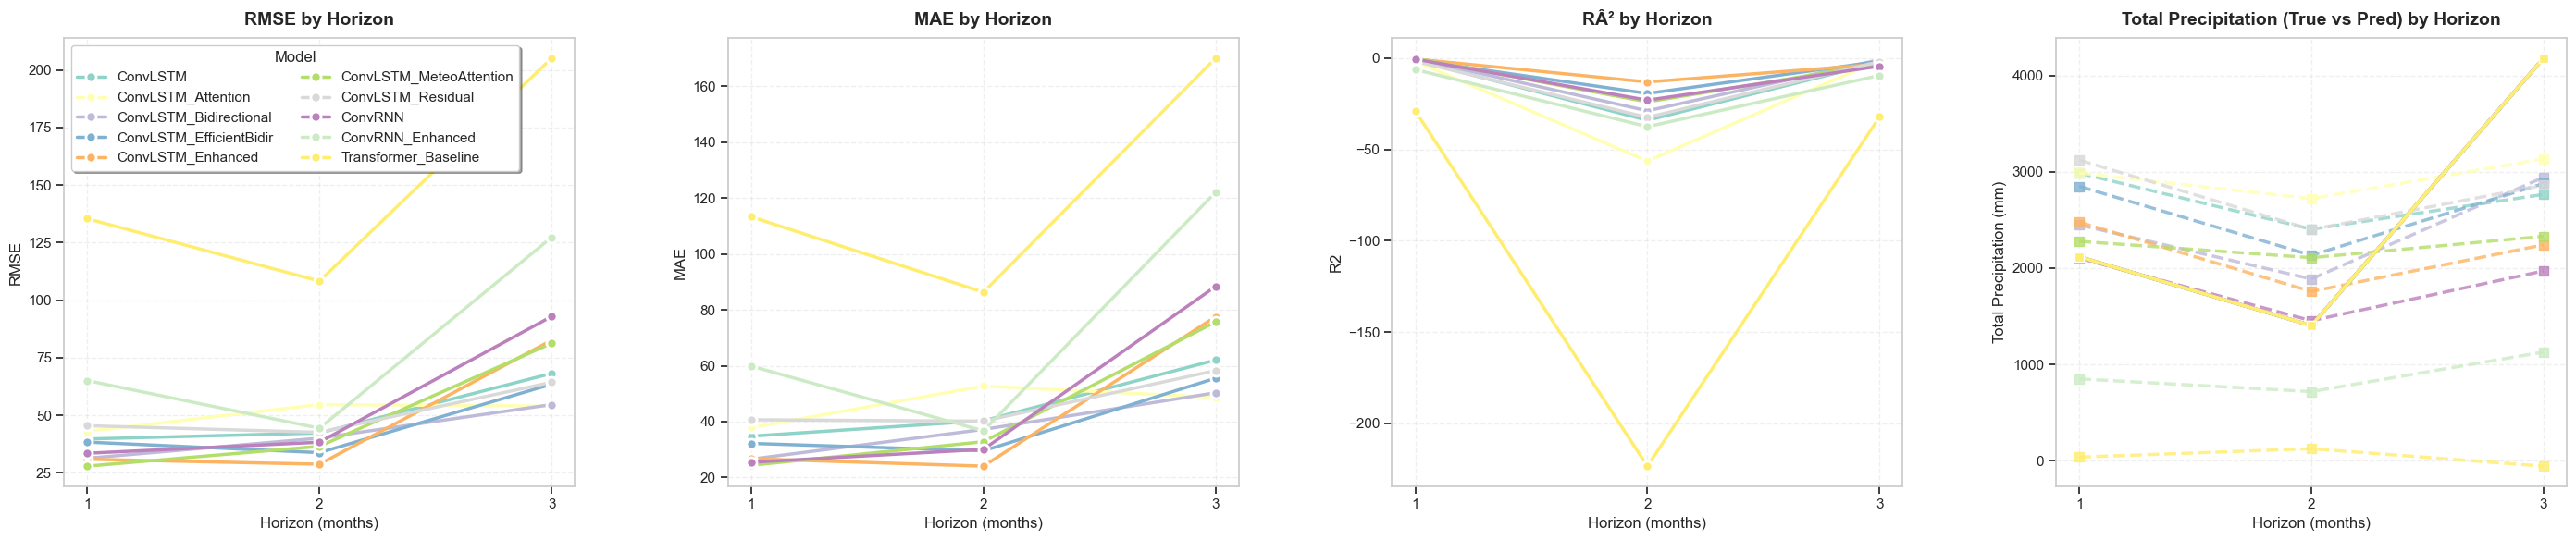

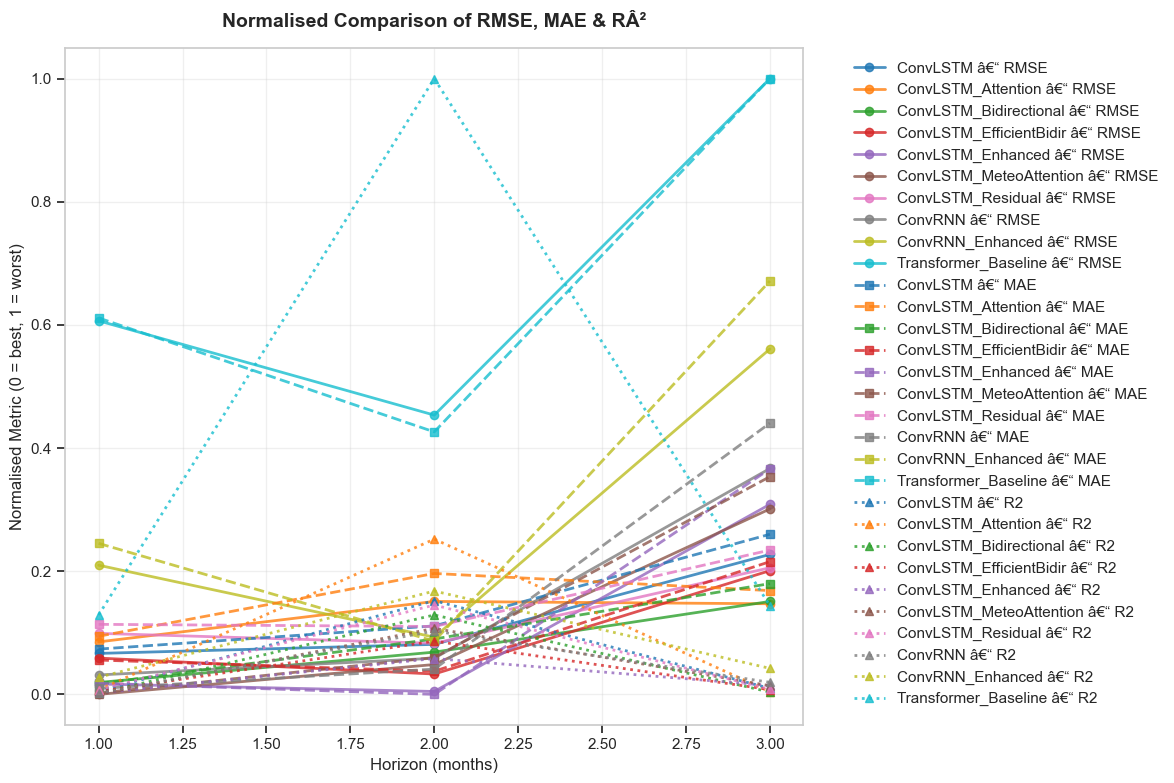

Enhanced plots saved to: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V2_Enhanced_Models\comparisons


In [24]:
# ==================================================
# METRICS EVOLUTION PLOTS
# ==================================================

print("\n Generating enhanced evolution-by-horizon plots...")

if not res_df.empty:
    # Individual metrics per horizon
    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    metrics = ['RMSE', 'MAE', 'R2', 'TotalPrecipitation']
    titles = ['RMSE by Horizon', 'MAE by Horizon', 'R^2 by Horizon', 'Total Precipitation (True vs Pred) by Horizon']
    colors = plt.cm.Set3(np.linspace(0, 1, len(res_df['Model'].unique())))

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]
        if metric != 'TotalPrecipitation':
            data = res_df.groupby(['H', 'Model'])[metric].mean().unstack()
            for i, model in enumerate(data.columns):
                ax.plot(data.index, data[model], marker='o', label=model, color=colors[i],
                        linewidth=2.5, markersize=8, markeredgewidth=2, markeredgecolor='white')
        else:
            data_true = res_df.groupby(['H', 'Model'])['TotalPrecipitation'].mean().unstack()
            data_pred = res_df.groupby(['H', 'Model'])['TotalPrecipitation_Pred'].mean().unstack()
            for i, model in enumerate(data_true.columns):
                ax.plot(data_true.index, data_true[model], marker='s', label=f'{model} Ã¢â‚¬â€œ True',
                        color=colors[i], linewidth=2.5, markersize=7, markeredgecolor='white')
                ax.plot(data_pred.index, data_pred[model], marker='s', label=f'{model} Ã¢â‚¬â€œ Pred',
                        color=colors[i], linewidth=2.5, linestyle='--', alpha=0.8, markersize=7)
        ylabel = metric if metric not in ('TotalPrecipitation', 'TotalPrecipitation_Pred') else 'Total Precipitation (mm)'
        ax.set_xlabel('Horizon (months)', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(sorted(res_df['H'].unique()))
        if idx == 0:
            ax.legend(title='Model', loc='best', frameon=True, fancybox=True, shadow=True, ncol=2)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.savefig(comp_dir / 'metrics_evolution_by_horizon.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Normalized multi-metric comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    for metric in ['RMSE', 'MAE', 'R2']:
        data = res_df.groupby(['H', 'Model'])[metric].mean().unstack()
        if metric == 'R2':
            data_norm = 1 - (data - data.min().min()) / (data.max().max() - data.min().min() + 1e-9)
        else:
            data_norm = (data - data.min().min()) / (data.max().max() - data.min().min() + 1e-9)
        for i, model in enumerate(data_norm.columns):
            linestyle = '-' if metric == 'RMSE' else '--' if metric == 'MAE' else ':'
            marker = 'o' if metric == 'RMSE' else 's' if metric == 'MAE' else '^'
            ax.plot(data_norm.index, data_norm[model], marker=marker, linewidth=2, linestyle=linestyle,
                    label=f'{model} Ã¢â‚¬â€œ {metric}', alpha=0.8)
    ax.set_xlabel('Horizon (months)', fontsize=12)
    ax.set_ylabel('Normalised Metric (0 = best, 1 = worst)', fontsize=12)
    ax.set_title('Normalised Comparison of RMSE, MAE & RÃ‚Â²', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.savefig(comp_dir / 'normalized_metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Enhanced plots saved to:", comp_dir)



 Generating visual metrics table...


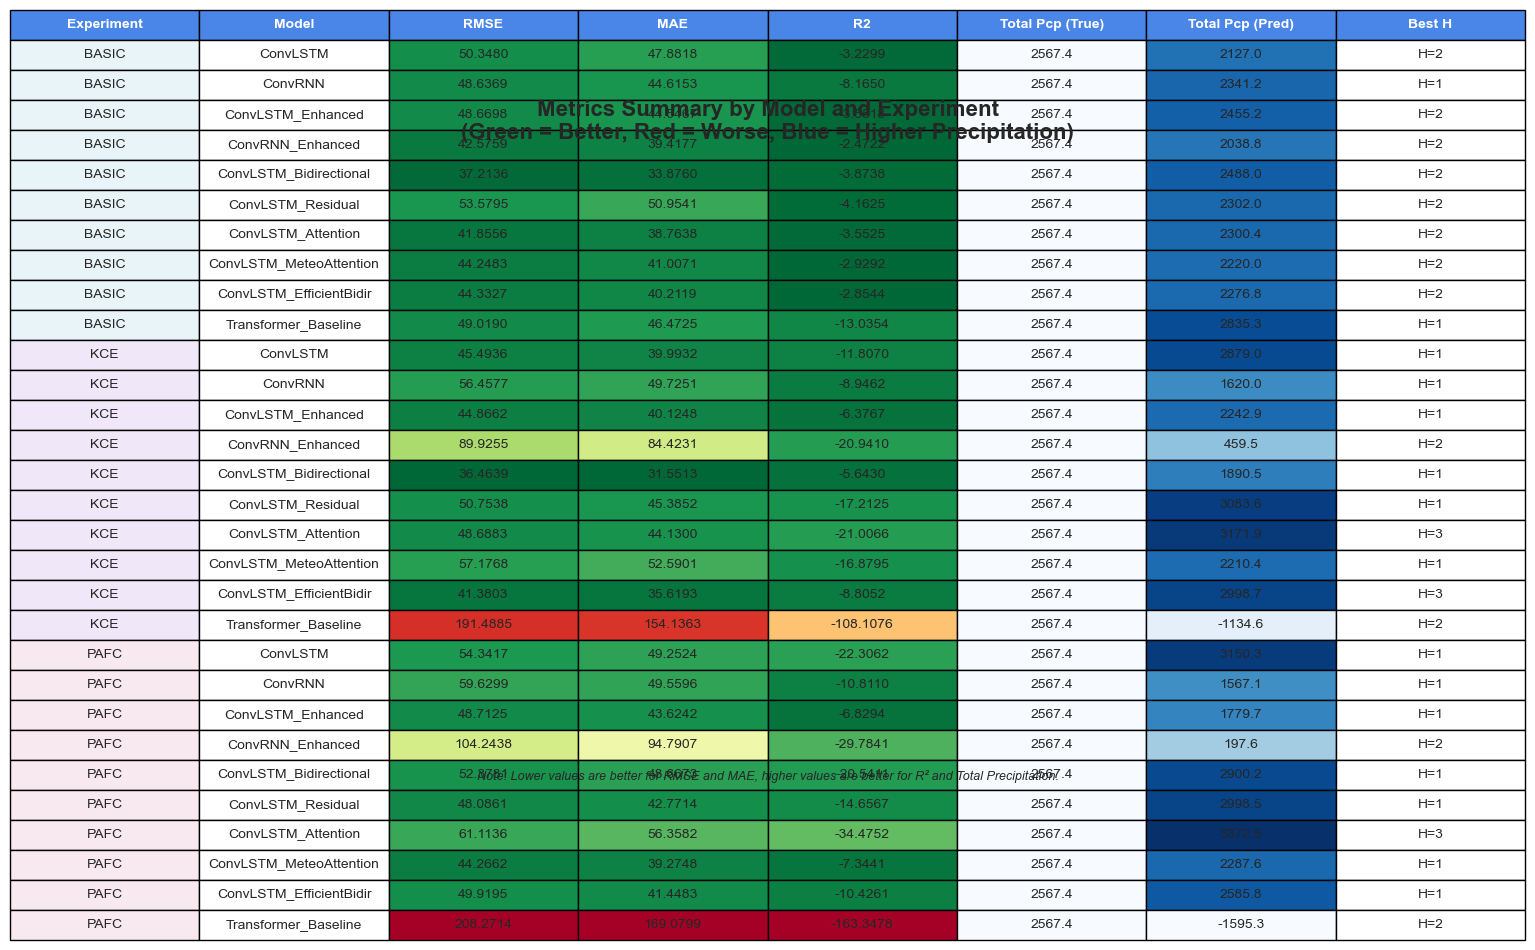


 BEST OVERALL MODEL:
Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬Ã¢â€â‚¬
Model:                 ConvLSTM_EfficientBidir
Experiment:            KCE
Horizon:               3
RMSE:                  36.2120
MAE:                   28.7473
RÃ‚Â²:                    0.1851
Total Precipitation:   4180.4
Composite score:       0.9664

 All visualizations generated and saved!


In [27]:
# ==================================================
# VISUAL METRICS TABLE AND BEST MODEL
# ==================================================

print("\n Generating visual metrics table...")

if not res_df.empty:
    summary_data = []
    experiments = res_df['Experiment'].unique()
    models = res_df['Model'].unique()
    headers = ['Experiment', 'Model', 'RMSE', 'MAE', 'R2', 'Total Pcp (True)', 'Total Pcp (Pred)', 'Best H']

    for exp in experiments:
        for model in models:
            sub = res_df[(res_df['Experiment'] == exp) & (res_df['Model'] == model)]
            if sub.empty:
                continue
            avg_rmse = sub['RMSE'].mean()
            avg_mae = sub['MAE'].mean()
            avg_r2 = sub['R2'].mean()
            avg_tp_t = sub['TotalPrecipitation'].mean()
            avg_tp_p = sub['TotalPrecipitation_Pred'].mean()
            best_h = sub.loc[sub['RMSE'].idxmin(), 'H']
            summary_data.append([
                exp, model,
                f'{avg_rmse:.4f}', f'{avg_mae:.4f}', f'{avg_r2:.4f}',
                f'{avg_tp_t:.1f}', f'{avg_tp_p:.1f}', f'H={best_h}'
            ])

    fig, ax = plt.subplots(figsize=(17, 8))
    ax.axis('off')
    table = ax.table(cellText=summary_data, colLabels=headers, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.15, 1.8)

    all_rmse = [float(r[2]) for r in summary_data]
    all_mae = [float(r[3]) for r in summary_data]
    all_r2 = [float(r[4]) for r in summary_data]
    all_tp_t = [float(r[5]) for r in summary_data]
    all_tp_p = [float(r[6]) for r in summary_data]

    for i, row in enumerate(summary_data):
        rmse = float(row[2]); mae = float(row[3])
        r2 = float(row[4]); tp_t = float(row[5]); tp_p = float(row[6])
        rmse_norm = (rmse - min(all_rmse)) / (max(all_rmse) - min(all_rmse) + 1e-9)
        mae_norm = (mae - min(all_mae)) / (max(all_mae) - min(all_mae) + 1e-9)
        table[(i+1, 2)].set_facecolor(plt.cm.RdYlGn(1 - rmse_norm))
        table[(i+1, 3)].set_facecolor(plt.cm.RdYlGn(1 - mae_norm))
        r2_norm = (r2 - min(all_r2)) / (max(all_r2) - min(all_r2) + 1e-9)
        table[(i+1, 4)].set_facecolor(plt.cm.RdYlGn(r2_norm))
        tp_t_norm = (tp_t - min(all_tp_t)) / (max(all_tp_t) - min(all_tp_t) + 1e-9)
        tp_p_norm = (tp_p - min(all_tp_p)) / (max(all_tp_p) - min(all_tp_p) + 1e-9)
        table[(i+1, 5)].set_facecolor(plt.cm.Blues(tp_t_norm))
        table[(i+1, 6)].set_facecolor(plt.cm.Blues(tp_p_norm))
        pastel = {'BASIC': '#e8f4f8', 'KCE': '#f0e8f8', 'PAFC': '#f8e8f0'}
        table[(i+1, 0)].set_facecolor(pastel.get(row[0], '#ffffff'))

    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#4a86e8')
        table[(0, j)].set_text_props(weight='bold', color='white')

    fig.suptitle('Metrics Summary by Model and Experiment
(Green = Better, Red = Worse, Blue = Higher Precipitation)',
              fontsize=16, fontweight='bold', pad=20)
# footnote removed due to encoding issues
    fig.text(0.5, 0.01, "Note: Lower values are better for RMSE and MAE, higher values are better for R^2 and Total Precipitation.",
                 ha='center', va='center',  fontsize=9, style='italic')
    plt.savefig(comp_dir / 'metrics_summary_table.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Best overall model
    print("\n BEST OVERALL MODEL:")
    print("Ã¢â€â‚¬" * 50)
    res_df['score'] = (
        (1 - (res_df['RMSE'] - res_df['RMSE'].min()) / (res_df['RMSE'].max() - res_df['RMSE'].min())) +
        (1 - (res_df['MAE'] - res_df['MAE'].min()) / (res_df['MAE'].max() - res_df['MAE'].min())) +
        ((res_df['R2'] - res_df['R2'].min()) / (res_df['R2'].max() - res_df['R2'].min())) +
        ((res_df['TotalPrecipitation'] - res_df['TotalPrecipitation'].min()) / (res_df['TotalPrecipitation'].max() - res_df['TotalPrecipitation'].min()))
    ) / 4
    best = res_df.loc[res_df['score'].idxmax()]
    print(f"Model:                 {best['Model']}")
    print(f"Experiment:            {best['Experiment']}")
    print(f"Horizon:               {best['H']}")
    print(f"RMSE:                  {best['RMSE']:.4f}")
    print(f"MAE:                   {best['MAE']:.4f}")
    print(f"RÃ‚Â²:                    {best['R2']:.4f}")
    print(f"Total Precipitation:   {best['TotalPrecipitation']:.1f}")
    print(f"Composite score:       {best['score']:.4f}")

print("\n All visualizations generated and saved!")

plt.subplots_adjust(top=0.88)


In [28]:
# ==================================================
# CLEANUP AND TERMINATION
# ==================================================

print("TRAINING AND ANALYSIS COMPLETED!")
print(f"Models trained: {len(MODELS)} architectures")
print(f"Experiments completed: {len(CONFIG['feature_sets'])}")
print(f"Results saved to: {CONFIG['out_root']}")

# Cleanup
tf.keras.backend.clear_session()
gc.collect()
print("Memory cleared")

if IN_COLAB:
    print("\nTerminating Colab session to save resources...")
    from google.colab import runtime
    runtime.unassign()
else:
    print("\nLocal environment detected. Session remains active.")


TRAINING AND ANALYSIS COMPLETED!
Models trained: 14 architectures
Experiments completed: 3
Results saved to: d:\github.com\ninja-marduk\ml_precipitation_prediction\models\output\V2_Enhanced_Models
Memory cleared

Local environment detected. Session remains active.
